In [ ]:
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

from statistics import mean

from google.colab import drive
drive.mount('/content/drive')

from drive.MyDrive.code.treenets.utils import TreeData, train_model, test_model

from drive.MyDrive.code.treenets.weightnet import WeightNet
from drive.MyDrive.code.treenets.localnet import LocalNet
from drive.MyDrive.code.treenets.oraclenet import OracleNet
from drive.MyDrive.code.treenets.fcnet import FCNet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def experiment(num_layers, train_size_list, test_size, noise_eps,
               num_epochs_list, num_iters_list, batch_size=32):
  for train_size, num_epochs, num_iters in zip(train_size_list, num_epochs_list,
                                               num_iters_list):
    for i in range(num_iters):
      tree_data = TreeData(num_layers, F.tanh)
      train_data = tree_data.generate_data(train_size, noise_eps)
      test_data = tree_data.generate_data(test_size, 0)

      trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
      testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

      test_loss_dict = {}

      weight_net = WeightNet(num_layers, F.tanh)
      weight_criterion = nn.MSELoss()
      weight_optimizer = optim.Adam(weight_net.parameters(), lr=1e-3)
      weight_scheduler = optim.lr_scheduler.StepLR(weight_optimizer,
                                                   num_epochs/2, 0.1)

      train_model(trainloader, weight_net, weight_criterion, weight_optimizer,
                  weight_scheduler, num_epochs)
      weight_loss = test_model(testloader, weight_net, weight_criterion)
      test_loss_dict['weight'] = weight_loss

      local_net = LocalNet(num_layers, F.tanh)
      local_criterion = nn.MSELoss()
      local_optimizer = optim.Adam(local_net.parameters(), lr=1e-3)
      local_scheduler = optim.lr_scheduler.StepLR(local_optimizer,
                                                  num_epochs/2, 0.1)

      train_model(trainloader, local_net, local_criterion, local_optimizer,
                  local_scheduler, num_epochs)
      local_loss = test_model(testloader, local_net, local_criterion)
      test_loss_dict['local'] = local_loss

      oracle_net = OracleNet(num_layers, F.tanh)
      oracle_criterion = nn.MSELoss()
      oracle_optimizer = optim.Adam(oracle_net.parameters(), lr=1e-3)
      oracle_scheduler = optim.lr_scheduler.StepLR(oracle_optimizer,
                                                   num_epochs/2, 0.1)

      train_model(trainloader, oracle_net, oracle_criterion, oracle_optimizer,
                  oracle_scheduler, num_epochs)
      oracle_loss = test_model(testloader, oracle_net, oracle_criterion)
      test_loss_dict['oracle'] = oracle_loss

      fc_net = FCNet(num_layers, F.tanh)
      fc_criterion = nn.MSELoss()
      fc_optimizer = optim.Adam(fc_net.parameters(), lr=1e-3)
      fc_scheduler = optim.lr_scheduler.StepLR(fc_optimizer, num_epochs/2, 0.1)

      train_model(trainloader, fc_net, fc_criterion, fc_optimizer,
                  fc_scheduler, num_epochs)
      fc_loss = test_model(testloader, fc_net, fc_criterion)
      test_loss_dict['fc'] = fc_loss

      with open('drive/MyDrive/code/treenets/results/weightlist-{}-{}-{}.pkl'
                .format(str(train_size), str(noise_eps), str(i)), 'wb+') as f:
        pickle.dump(tree_data.weight_list, f)
      with open('drive/MyDrive/code/treenets/results/testloss-{}-{}-{}.pkl'
                .format(str(train_size), str(noise_eps), str(i)), 'wb+') as f:
        pickle.dump(test_loss_dict, f)

      torch.save(weight_net.state_dict(),
                 'drive/MyDrive/code/treenets/results/weight-{}-{}-{}.pth'
                 .format(str(train_size), str(noise_eps), str(i)))
      torch.save(local_net.state_dict(),
                 'drive/MyDrive/code/treenets/results/local-{}-{}-{}.pth'
                 .format(str(train_size), str(noise_eps), str(i)))
      torch.save(oracle_net.state_dict(),
                 'drive/MyDrive/code/treenets/results/oracle-{}-{}-{}.pth'
                 .format(str(train_size), str(noise_eps), str(i)))
      torch.save(fc_net.state_dict(),
                 'drive/MyDrive/code/treenets/results/fc-{}-{}-{}.pth'
                 .format(str(train_size), str(noise_eps), str(i)))

In [ ]:
num_layers = 6
train_size_list = [64, 128, 256, 512, 1024, 2048, 4096]
test_size = 1024
noise_eps_list = [0, 0.1, 0.3]
num_epochs_list = [800, 700, 600, 500, 400, 300, 200]
num_iters_list = [8, 7, 6, 5, 4, 3, 2]

In [ ]:
for noise_eps in noise_eps_list:
  experiment(num_layers, train_size_list, test_size, noise_eps, num_epochs_list,
             num_iters_list)

In [59]:
def load_weight_net(num_layers, train_size, noise_eps, i):
  weight_net = WeightNet(num_layers, F.tanh)
  weight_net.load_state_dict(torch.load('drive/MyDrive/code/treenets/results/weight-{}-{}-{}.pth'
                                        .format(str(train_size), str(noise_eps), str(i))))
  return weight_net

def load_local_net(num_layers, train_size, noise_eps, i):
  local_net = LocalNet(num_layers, F.tanh)
  local_net.load_state_dict(torch.load('drive/MyDrive/code/treenets/results/local-{}-{}-{}.pth'
                                       .format(str(train_size), str(noise_eps), str(i))))
  return local_net

def load_oracle_net(num_layers, train_size, noise_eps, i):
  oracle_net = OracleNet(num_layers, F.tanh)
  oracle_net.load_state_dict(torch.load('drive/MyDrive/code/treenets/results/oracle-{}-{}-{}.pth'
                                        .format(str(train_size), str(noise_eps), str(i))))
  return oracle_net

def load_fc_net(num_layers, train_size, noise_eps, i):
  fc_net = FCNet(num_layers, F.tanh)
  fc_net.load_state_dict(torch.load('drive/MyDrive/code/treenets/results/fc-{}-{}-{}.pth'
                                    .format(str(train_size), str(noise_eps), str(i))))
  return fc_net

def load_pickles(train_size, noise_eps, i):
  with open('drive/MyDrive/code/treenets/results/weightlist-{}-{}-{}.pkl'
            .format(str(train_size), str(noise_eps), str(i)), 'rb') as f:
    weight_list = pickle.load(f)
  with open('drive/MyDrive/code/treenets/results/testloss-{}-{}-{}.pkl'
            .format(str(train_size), str(noise_eps), str(i)), 'rb') as f:
    test_loss_dict = pickle.load(f)
  
  return weight_list, test_loss_dict

In [ ]:
all_loss_dict = {noise_eps: {'weight': [],
                             'local': [],
                             'oracle': [],
                             'fc': []} for noise_eps in [0, 0.1, 0.3]} 

for noise_eps in [0, 0.1, 0.3]:
  for train_size, num_iters in zip(train_size_list, num_iters_list):
    cur_loss_dict = {'weight': [],
                     'local': [],
                     'oracle': [],
                     'fc': []}

    for i in range(num_iters):
      _, test_loss_dict = load_pickles(train_size, noise_eps, i)
      for k in ['weight', 'local', 'oracle', 'fc']:
        cur_loss_dict[k].append(test_loss_dict[k].item())

    for k in ['weight', 'local', 'oracle', 'fc']:
      all_loss_dict[noise_eps][k].append(mean(cur_loss_dict[k]))

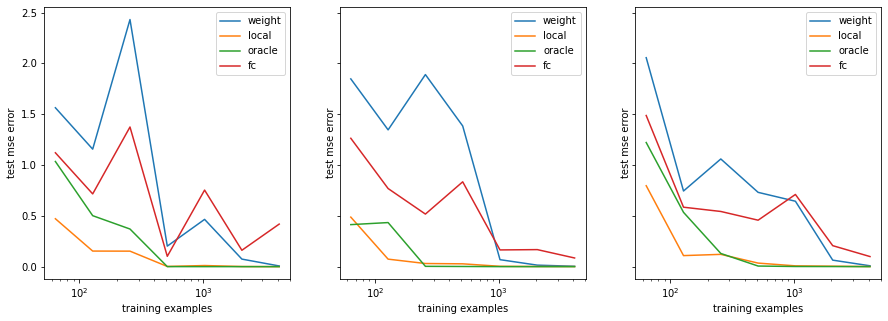

In [50]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for ax, noise_eps in [(ax1, 0), (ax2, 0.1), (ax3, 0.3)]:
  ax.set_xscale('log')
  ax.plot(train_size_list, all_loss_dict[noise_eps]['weight'], label='weight')
  ax.plot(train_size_list, all_loss_dict[noise_eps]['local'], label='local')
  ax.plot(train_size_list, all_loss_dict[noise_eps]['oracle'], label='oracle')
  ax.plot(train_size_list, all_loss_dict[noise_eps]['fc'], label='fc')
  ax.legend()
  ax.set_xlabel('training examples')
  ax.set_ylabel('test mse error')

plt.savefig('drive/MyDrive/code/figures/tree_losses.png')
plt.show()

In [121]:
train_size, noise_eps, i = 512, 0, 0

true_weights, loss_dict = load_pickles(train_size, noise_eps, i)
weight_net = load_weight_net(num_layers, train_size, noise_eps, i)
local_net = load_local_net(num_layers, train_size, noise_eps, i)

weight_layer = weight_net.get_submodule('layers.0')
local_layer = local_net.get_submodule('layers.0')

weight_weights_0 = torch.cat([param for param in weight_layer.parameters()])[:,0::2]
weight_weights_1 = torch.cat([param for param in weight_layer.parameters()])[:,1::2]
local_weights_0 = torch.cat([param for param in local_layer.parameters()], dim=1)[:,0::2]
local_weights_1 = torch.cat([param for param in local_layer.parameters()], dim=1)[:,1::2]

In [122]:
loss_dict, true_weights[0], weight_weights_0, weight_weights_1, local_weights_0, local_weights_1

({'fc': tensor(0.0829),
  'local': tensor(0.0015),
  'oracle': tensor(1.1983e-05),
  'weight': tensor(0.0818)},
 tensor([[0.6248],
         [0.4908]]),
 tensor([[ 0.0705,  0.2155, -0.1696, -0.2224,  0.0376, -0.0416, -0.3736, -0.1657,
          -0.3267,  0.0243, -0.1083,  0.1721, -0.0129,  0.0334,  0.0190,  0.0614,
           0.1180,  0.0843, -0.1668, -0.0844, -0.1575, -0.1095, -0.0727,  0.0339,
           0.0999,  0.1415,  0.0043, -0.1464, -0.1454, -0.1055, -0.1802, -0.2253]],
        grad_fn=<SliceBackward0>),
 tensor([[ 0.1145,  0.0436, -0.3092, -0.1549, -0.2281, -0.1900, -0.1392, -0.0364,
          -0.0068,  0.0304,  0.0405,  0.0275, -0.1537,  0.0279, -0.1641,  0.1736,
           0.0613,  0.1098,  0.0439, -0.0212, -0.0255, -0.1085, -0.0837, -0.1617,
          -0.0842,  0.0895, -0.1065, -0.1208,  0.1285,  0.0431, -0.0589, -0.0818]],
        grad_fn=<SliceBackward0>),
 tensor([[ 0.7871,  0.6964,  0.4517,  0.6199, -0.6351,  0.7508, -0.4528, -0.7256,
           0.6509,  0.7631,  0.4115,

In [123]:
torch.max(torch.abs(weight_weights_0)), torch.max(torch.abs(weight_weights_1)), torch.mean(torch.abs(local_weights_0)), torch.mean(torch.abs(local_weights_1))

(tensor(0.3736, grad_fn=<MaxBackward1>),
 tensor(0.3092, grad_fn=<MaxBackward1>),
 tensor(0.5995, grad_fn=<MeanBackward0>),
 tensor(0.4967, grad_fn=<MeanBackward0>))

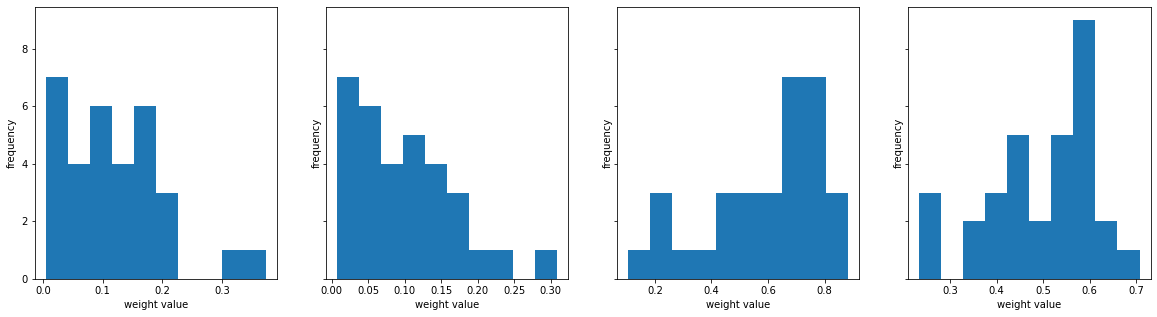

In [124]:
import numpy as np

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20,5))

for ax, data in [(ax1, weight_weights_0), (ax2, weight_weights_1), (ax3, local_weights_0), (ax4, local_weights_1)]:
  ax.hist(np.abs(torch.squeeze(data).detach().numpy()))
  ax.set_xlabel('weight value')
  ax.set_ylabel('frequency')

plt.savefig('drive/MyDrive/code/figures/tree_512_weights.png')
plt.show()

In [125]:
train_size, noise_eps, i = 4096, 0, 0

true_weights, loss_dict = load_pickles(train_size, noise_eps, i)
weight_net = load_weight_net(num_layers, train_size, noise_eps, i)
local_net = load_local_net(num_layers, train_size, noise_eps, i)

weight_layer = weight_net.get_submodule('layers.0')
local_layer = local_net.get_submodule('layers.0')

weight_weights_0 = torch.cat([param for param in weight_layer.parameters()])[:,0::2]
weight_weights_1 = torch.cat([param for param in weight_layer.parameters()])[:,1::2]
local_weights_0 = torch.cat([param for param in local_layer.parameters()], dim=1)[:,0::2]
local_weights_1 = torch.cat([param for param in local_layer.parameters()], dim=1)[:,1::2]

In [126]:
loss_dict, true_weights[0], weight_weights_0, weight_weights_1, local_weights_0, local_weights_1

({'fc': tensor(0.8373),
  'local': tensor(5.5118e-05),
  'oracle': tensor(9.1223e-10),
  'weight': tensor(0.0134)},
 tensor([[0.4973],
         [1.8477]]),
 tensor([[ 2.5294e-03, -2.6621e-03,  2.3757e-03, -9.3903e-04, -1.8019e-03,
          -1.0910e-03, -1.3315e-03,  2.7417e-03, -4.3740e-04,  3.3978e-05,
          -3.9725e-03,  1.7189e-03,  4.6685e-04,  3.5058e-04, -1.2495e-03,
          -1.7742e-03,  2.1956e-03, -2.1087e-02, -5.5246e-01, -6.5402e-03,
           4.8637e-03,  5.3683e-03, -2.5495e-03, -5.2442e-04, -1.5528e-03,
           4.1959e-03, -1.9999e-03,  1.9486e-03, -6.8041e-04,  3.2962e-03,
           4.1980e-03, -5.4859e-03]], grad_fn=<SliceBackward0>),
 tensor([[-4.1462e-04, -7.9789e-03, -1.4799e-03,  3.3158e-03,  6.7378e-04,
          -2.6304e-03, -1.3593e-03,  2.1984e-04, -5.7365e-03,  3.4031e-03,
          -2.3309e-03, -2.1172e-03,  1.4628e-03,  2.4128e-04, -2.3067e-03,
          -5.5350e-03,  1.1663e-02, -7.6854e-02, -2.0309e+00, -1.9152e-02,
           5.6960e-03,  7.091

In [127]:
torch.max(torch.abs(weight_weights_0)), torch.max(torch.abs(weight_weights_1)), torch.mean(torch.abs(local_weights_0)), torch.mean(torch.abs(local_weights_1))

(tensor(0.5525, grad_fn=<MaxBackward1>),
 tensor(2.0309, grad_fn=<MaxBackward1>),
 tensor(0.4950, grad_fn=<MeanBackward0>),
 tensor(1.8396, grad_fn=<MeanBackward0>))

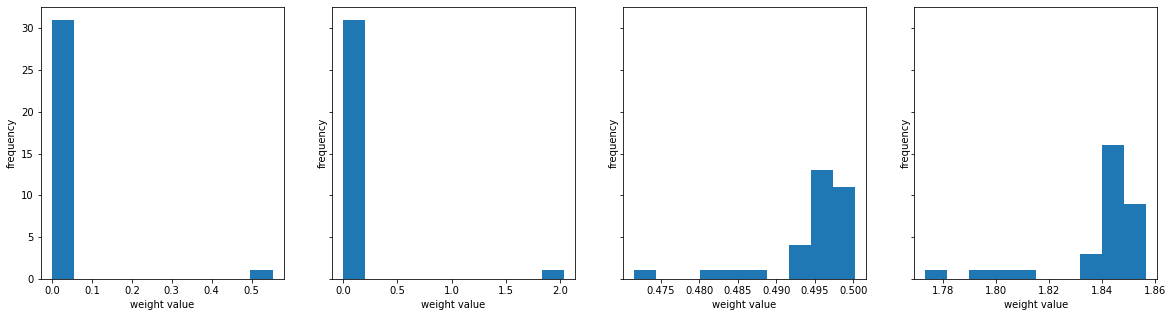

In [128]:
import numpy as np

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20,5))

for ax, data in [(ax1, weight_weights_0), (ax2, weight_weights_1), (ax3, local_weights_0), (ax4, local_weights_1)]:
  ax.hist(np.abs(torch.squeeze(data).detach().numpy()))
  ax.set_xlabel('weight value')
  ax.set_ylabel('frequency')

plt.savefig('drive/MyDrive/code/figures/tree_4096_weights.png')
plt.show()

Old code.

In [ ]:
num_layers = 6
tree_data = TreeData(num_layers, F.tanh)

In [ ]:
print(tree_data.weight_list)

[tensor([[0.6005],
        [1.3986]]), tensor([[0.9423],
        [1.0622]]), tensor([[1.2192],
        [1.2963]]), tensor([[0.4202],
        [1.6461]]), tensor([[0.2764],
        [1.4872]]), tensor([[0.3716],
        [0.4224]])]


In [ ]:
train_data = tree_data.generate_data(4096, 0)
test_data = tree_data.generate_data(256, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
print([y for _, y in test_data])

[tensor([0.7078]), tensor([0.0070]), tensor([0.3420]), tensor([-0.1772]), tensor([-0.6538]), tensor([0.3332]), tensor([-0.0418]), tensor([-0.0430]), tensor([0.0631]), tensor([-0.0979]), tensor([0.5215]), tensor([-0.4676]), tensor([0.6805]), tensor([0.5589]), tensor([-0.2708]), tensor([0.6661]), tensor([-0.5030]), tensor([0.6168]), tensor([-0.6601]), tensor([0.1831]), tensor([-0.4629]), tensor([-0.0542]), tensor([-0.6950]), tensor([0.4522]), tensor([0.6495]), tensor([-0.6706]), tensor([0.6490]), tensor([0.0118]), tensor([-0.5543]), tensor([-0.1503]), tensor([0.1394]), tensor([0.7249]), tensor([-0.6713]), tensor([-0.1983]), tensor([0.3577]), tensor([-0.5362]), tensor([0.5806]), tensor([0.6218]), tensor([-0.6251]), tensor([-0.5796]), tensor([-0.1442]), tensor([0.6483]), tensor([-0.6656]), tensor([0.6944]), tensor([0.3659]), tensor([-0.0908]), tensor([0.0573]), tensor([0.0015]), tensor([-0.6747]), tensor([0.3135]), tensor([0.0344]), tensor([-0.6732]), tensor([0.5185]), tensor([0.4917]), te

In [ ]:
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=8, shuffle=False)
num_epochs = 200

In [ ]:
weight_net = WeightNet(num_layers, F.tanh)
criterion = nn.MSELoss()
# optimizer = optim.SGD(weight_net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(weight_net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, num_epochs/2, 0.1)

In [ ]:
for _ in range(8):
  train_model(trainloader, weight_net, criterion, optimizer, scheduler, int(num_epochs/8))
  print(test_model(testloader, weight_net, criterion))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(0.0419)
tensor(0.0073)
tensor(0.0056)
tensor(0.0023)
tensor(0.0012)
tensor(0.0007)
tensor(0.0004)
tensor(0.0002)


In [ ]:
test_model(testloader, weight_net, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(0.0002)

In [ ]:
for name, param in weight_net.named_parameters():
  print(name, param)

layers.0.weight Parameter containing:
tensor([[-2.6257e-04, -9.1508e-04,  8.4587e-04, -6.6151e-05, -4.8836e-04,
          1.5462e-03,  6.9122e-04, -2.0534e-04, -1.4258e-03, -1.7506e-03,
          1.4803e-03, -2.5591e-04,  4.7169e-05,  8.8485e-04, -4.0913e-04,
          7.4449e-04, -6.0104e-01, -1.4008e+00, -9.7891e-05, -1.4829e-03,
          7.9574e-05,  2.8769e-04, -4.6703e-04, -6.9950e-04,  1.9003e-04,
          1.4444e-03,  4.9651e-04, -1.4443e-03,  1.2159e-03, -1.9635e-04,
          2.5019e-04,  1.6672e-05, -2.9881e-04,  2.3761e-04,  9.2042e-04,
         -3.6307e-05, -9.9871e-04,  4.2345e-04, -9.1748e-04, -5.5649e-04,
          5.3700e-04, -2.1229e-03, -2.2096e-04,  8.6097e-04, -5.1763e-04,
         -2.3353e-04, -7.4817e-04, -1.5767e-03,  1.6685e-04, -8.2505e-04,
          9.1505e-04,  8.3910e-04,  8.6695e-05, -6.2642e-04, -2.3268e-03,
          6.7302e-04,  1.0807e-03,  7.3251e-05,  2.9119e-04, -4.2637e-04,
         -1.2829e-03,  3.1271e-04,  8.1454e-04,  5.9611e-04]],
       requ

In [ ]:
local_net = LocalNet(num_layers, F.tanh)
criterion = nn.MSELoss()
# optimizer = optim.SGD(local_net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(local_net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, num_epochs/2, 0.1)

In [ ]:
for _ in range(8):
  train_model(trainloader, local_net, criterion, optimizer, scheduler, int(num_epochs/8))
  print(test_model(testloader, local_net, criterion))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(0.0021)
tensor(0.0004)
tensor(6.0166e-05)
tensor(8.3270e-06)
tensor(6.6002e-06)
tensor(4.7400e-06)


KeyboardInterrupt: ignored

In [ ]:
test_model(testloader, local_net, criterion)

In [ ]:
for name, param in local_net.named_parameters():
  print(name, param)

In [ ]:
oracle_net = OracleNet(num_layers, F.tanh)
criterion = nn.MSELoss()
optimizer = optim.SGD(oracle_net.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, num_epochs/2, 0.1)

In [ ]:
for _ in range(2):
  train_model(trainloader, oracle_net, criterion, optimizer, scheduler, int(num_epochs/2))
  print(test_model(testloader, oracle_net, criterion))

In [ ]:
test_model(testloader, oracle_net, criterion)

In [ ]:
fc_net = FCNet(num_layers, F.tanh)
criterion = nn.MSELoss()
optimizer = optim.SGD(fc_net.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, num_epochs/2, 0.1)

In [ ]:
for _ in range(2):
  train_model(trainloader, fc_net, criterion, optimizer, scheduler, int(num_epochs/2))
  print(test_model(testloader, fc_net, criterion))

In [ ]:
test_model(testloader, fc_net, criterion)